In [0]:
## Copyright (C) 2019 - Chase Yang - yang8571@gmail.com

import numpy as np
from keras import datasets
from keras import models,layers
from matplotlib import pyplot as plt

In [0]:
# (X_train, _), (X_test, __) = datasets.mnist.load_data()
(X_train, _), (X_test, __) = datasets.cifar100.load_data()

In [0]:
import cv2

def img_preprocess(image) :
  if image.shape == (28,28,1) :
    image = np.reshape(image, (28, 28))
  image = image *255
  image = image.astype('int')
  return image

def show_img(image) :
  image = img_preprocess(image)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image,cmap=plt.cm.binary)
  plt.show()

def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  elif noise_typ == "s&p" :
    noisy = image + 0.9 * image.std() * np.random.random(image.shape)
    return noisy
  elif noise_typ == "poisson" :
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

Original Data :


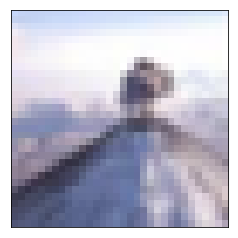

In [79]:
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

if (X_train[0].shape == (28,28)) :
  X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
  X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

input_shape = X_train[0].shape
print("Original Data :")
show_img(X_test[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noised Data :


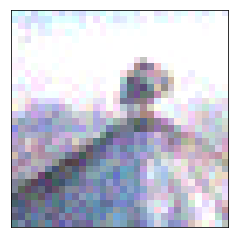

In [80]:
Xn_train = np.copy(X_train)
Xn_test = np.copy(X_test)


for i in range(0,len(Xn_train)) :      
  Xn_train[i] = noisy("s&p", Xn_train[i])


for i in range(0,len(Xn_test)) :
  Xn_test[i] = noisy("s&p", Xn_test[i])
  if i == 0 :
    print("Noised Data :")
    show_img(Xn_test[i])

In [0]:
n_filters = [16,32,64]

##Model for Cifar100
encoder = models.Sequential([
    layers.Conv2D(n_filters[0], kernel_size=(3,3), activation = 'relu', padding='same', input_shape = input_shape),
    layers.Conv2D(n_filters[1], kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    layers.Conv2D(n_filters[2], kernel_size=(3,3), activation = 'relu')
])

decoder = models.Sequential([
    layers.Deconv2D(n_filters[1],kernel_size=(3,3),activation = 'relu'),
    layers.UpSampling2D((2,2)),
    layers.Deconv2D(n_filters[0],kernel_size=(3,3),activation = 'relu'),
    layers.Deconv2D(input_shape[2], kernel_size = (3,3), activation = 'sigmoid', padding='same')
])

# decoder = encoder.layers[-1]

## Model for MNIST
# if input_shape == (28,28,1) :
#   encoder = models.Sequential([
#       layers.Conv2D(16, kernel_size=(3,3), activation = 'relu',padding='same', input_shape = input_shape),
#       layers.MaxPooling2D(pool_size=(2,2),padding='same'),
#       layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', padding='same'),
#       layers.MaxPooling2D(pool_size=(2,2),padding='same')
#   ])
#   decoder = models.Sequential([
#       layers.Conv2D(32,kernel_size=(3,3),activation = 'relu', padding='same'),
#       layers.UpSampling2D((2,2)),
#       layers.Conv2D(16,kernel_size=(3,3),activation = 'relu', padding='same'),
# #       layers.Conv2D(16,kernel_size=(3,3),activation = 'relu'),
#       layers.UpSampling2D((2,2)),
#       layers.Conv2D(input_shape[2], kernel_size = (3,3), activation = 'sigmoid', padding='same')
#   ])


model = models.Sequential([
    encoder,
    decoder
])

model.compile(optimizer = 'adam', 
             loss = 'binary_crossentropy')

In [84]:
history = model.fit(X_train, X_train, epochs=30, validation_split=0.2, batch_size=128, verbose = 1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 7s 169us/step - loss: 0.5606 - val_loss: 0.5376
Epoch 2/30
40000/40000 [==============================] - 5s 133us/step - loss: 0.5371 - val_loss: 0.5327
Epoch 3/30
40000/40000 [==============================] - 5s 132us/step - loss: 0.5344 - val_loss: 0.5309
Epoch 4/30
40000/40000 [==============================] - 5s 132us/step - loss: 0.5328 - val_loss: 0.5298
Epoch 5/30
40000/40000 [==============================] - 5s 131us/step - loss: 0.5320 - val_loss: 0.5289
Epoch 6/30
40000/40000 [==============================] - 5s 130us/step - loss: 0.5314 - val_loss: 0.5288
Epoch 7/30
40000/40000 [==============================] - 5s 131us/step - loss: 0.5307 - val_loss: 0.5279
Epoch 8/30
40000/40000 [==============================] - 5s 135us/step - loss: 0.5304 - val_loss: 0.5274
Epoch 9/30
40000/40000 [==============================] - 5s 136us/step - loss: 0.5301 - val_loss: 0.5

In [0]:
predict = model.predict(X_test)

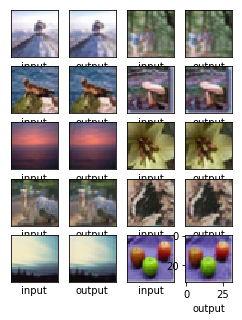

In [86]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols

plt.figure(figsize=(2*num_cols, num_rows))

for i in range(num_images):
  plt.xticks([])
  plt.yticks([])
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plt.xlabel("input")
  image = img_preprocess(X_test[i])
  plt.imshow(image)

  
  plt.xticks([])
  plt.yticks([])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plt.xlabel("output")
  image = img_preprocess(predict[i])
  plt.imshow(image)

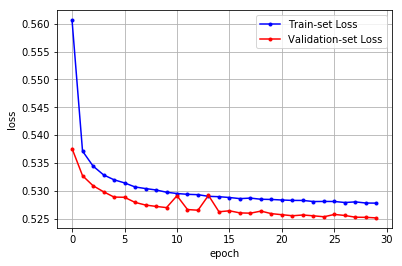

In [87]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
denoiser = models.Sequential([
    layers.Conv2D(n_filters[2], kernel_size=(3,3), activation = 'relu', padding='same'),
    layers.Conv2D(n_filters[2], kernel_size=(3,3), activation = 'relu', padding='same')
])

encoder.trainable = False
decoder.trainable = False

model_2 = models.Sequential([
    encoder,
    denoiser,
    decoder
])

model_2.compile(optimizer = 'adam', 
             loss = 'binary_crossentropy')

In [89]:
history_2 = model_2.fit(Xn_train, X_train, epochs=30, validation_split=0.2, batch_size=128, verbose = 1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 6s 151us/step - loss: 0.5530 - val_loss: 0.5353
Epoch 2/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.5360 - val_loss: 0.5326
Epoch 3/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.5343 - val_loss: 0.5317
Epoch 4/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.5334 - val_loss: 0.5310
Epoch 5/30
40000/40000 [==============================] - 5s 123us/step - loss: 0.5330 - val_loss: 0.5302
Epoch 6/30
40000/40000 [==============================] - 5s 122us/step - loss: 0.5326 - val_loss: 0.5303
Epoch 7/30
40000/40000 [==============================] - 5s 122us/step - loss: 0.5323 - val_loss: 0.5298
Epoch 8/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.5322 - val_loss: 0.5295
Epoch 9/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.5319 - val_loss: 0.5

In [0]:
predict_2 = model_2.predict(Xn_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

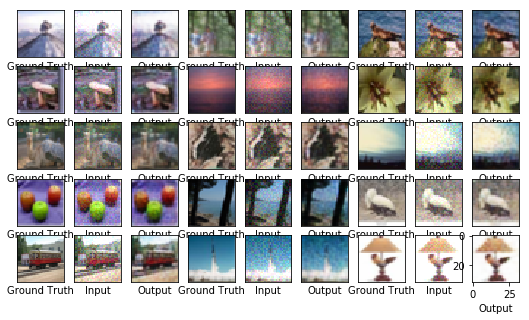

In [91]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(3*num_cols, num_rows))

for i in range(num_images):
  plt.xticks([])
  plt.yticks([])
  plt.subplot(num_rows, 3*num_cols, 3*i+1)
  plt.xlabel("Ground Truth")
  image = img_preprocess(X_test[i])
  plt.imshow(image)

  
  plt.xticks([])
  plt.yticks([])
  plt.subplot(num_rows, 3*num_cols, 3*i+2)
  plt.xlabel("Input")
  image = img_preprocess(Xn_test[i])
  plt.imshow(image)
  
  plt.xticks([])
  plt.yticks([])
  plt.subplot(num_rows, 3*num_cols, 3*i+3)
  plt.xlabel("Output")
  image = img_preprocess(predict_2[i])
  plt.imshow(image)

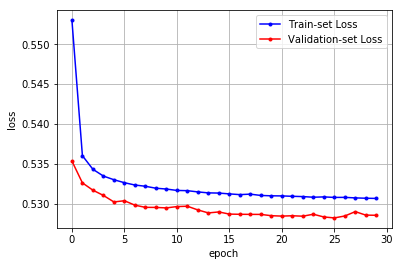

In [92]:
y_vloss = history_2.history['val_loss']
y_loss = history_2.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()